# Characters

EXISTING

This data frame lists all characters, their movie, their gender, and their credit position. The `character_ID` column is later referenced in other data frames.

## Table of Contents
- [1st Section](#Loading-in-the-data-and-basic-summary) is where I import the files and get an idea of the data shape and contents
- [2nd section](#Generating-gender-markers) is where I run the data through several functions to generate missing gender markers
- [3rd section](#Another-pass-at-gender-markers:-identifying-first-names) is where I focus on splitting names to identify first names
- [4th section](#Remerging-the-dataframes) puts all the data back together
- [5th section](#Pickling-the-data-and-creating-a-csv) is where the data are saved and exported
- [Conclusion](#Conclusion) summarizes the notebook

In [1]:
# import packages
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Loading in the data and basic summary

In [2]:
# creating the df
characters_df = pd.read_csv('../data/movie_characters_metadata.txt', sep='\s+\+\+\+\$\+\+\+\s?',
                            names = ['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender', 'credit_position'], 
                            dtype='string', engine='python', encoding='ISO-8859-1')

The data were all separated with ' +++$+++ ' and did not have column names. The README from the original data described what each column was in the data so I used that to create column names.

In [3]:
characters_df.shape

(9035, 6)

In [4]:
characters_df.info()
# some characters are unnamed, I will drop them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     9035 non-null   string
 1   character_name   9033 non-null   string
 2   movie_ID         9035 non-null   string
 3   movie_title      9035 non-null   string
 4   gender           9035 non-null   string
 5   credit_position  9035 non-null   string
dtypes: string(6)
memory usage: 423.6 KB


In [5]:
characters_df = characters_df.dropna()

In [6]:
characters_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [7]:
characters_df.tail()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
9030,u9030,DURNFORD,m616,zulu dawn,?,?
9031,u9031,MELVILL,m616,zulu dawn,?,?
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,?,?
9033,u9033,STUART SMITH,m616,zulu dawn,?,?
9034,u9034,VEREKER,m616,zulu dawn,?,?


Some gender makers are missing for characters in this dataframe, I will work on filling in the missing data.

In [8]:
# how many characters are missing gender?
characters_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
?,6018,6018,6018,6018,6018
F,45,45,45,45,45
M,150,150,150,150,150
f,921,921,921,921,921
m,1899,1899,1899,1899,1899


There are a lot of missing gender markers! Looks like some of the flags are inconsist too, there is 'm' and 'M.'

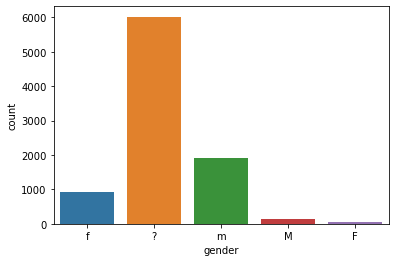

In [9]:
sns.countplot(x = "gender",
             data = characters_df)
plt.savefig('../data_visualization/initial_gender.png')
plt.show()

More characters are missing gender markers than have gender markers.

In [10]:
# making all gender markers uppercase
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'f', r'F', x))
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'm', r'M', x))

In [11]:
characters_df.describe()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
count,9033,9033,9033,9033,9033,9033
unique,9033,5355,617,617,3,57
top,u0,MAN,m289,casino,?,?
freq,1,44,44,44,6018,6354


In [12]:
# now that the markers are tidied up, let's look again
characters_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
?,6018,6018,6018,6018,6018
F,966,966,966,966,966
M,2049,2049,2049,2049,2049


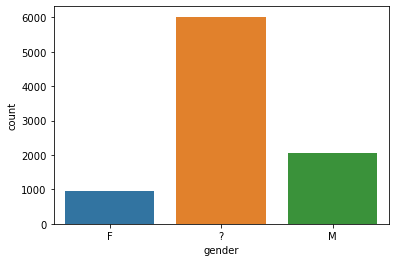

In [13]:
sns.countplot(x = "gender",
             data = characters_df)
plt.savefig('../data_visualization/gender_update1.png')
plt.show()

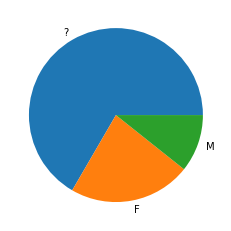

In [14]:
# another view of the gender split
plt.pie(characters_df.gender.value_counts(), labels=["?", "F", "M"])
plt.savefig('../data_visualization/gender_pie_initial.png')
plt.show()

A majority of the characters are missing gender markers. I will fill in as many of these as I can.

## Generating gender markers

In [15]:
# df for characters without gender markers
characters_ng1_df = characters_df[characters_df.gender == '?']

# df for characters with gender markers, these will get remerged later
characters_g1_df = characters_df[characters_df.gender != '?']

In [16]:
characters_ng1_df.info()
# a total of 6018 characters without gender

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 1 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     6018 non-null   string
 1   character_name   6018 non-null   string
 2   movie_ID         6018 non-null   string
 3   movie_title      6018 non-null   string
 4   gender           6018 non-null   object
 5   credit_position  6018 non-null   string
dtypes: object(1), string(5)
memory usage: 329.1+ KB


I will use the NLTK names list and specific strings to help fill in missing gender markers.

### NLTK names

In [17]:
# I will use the names corpus from NLTK to fill in some gaps in gender data
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

In [18]:
male_names[:10]

['Aamir',
 'Aaron',
 'Abbey',
 'Abbie',
 'Abbot',
 'Abbott',
 'Abby',
 'Abdel',
 'Abdul',
 'Abdulkarim']

In [19]:
female_names[:10]

['Abagael',
 'Abagail',
 'Abbe',
 'Abbey',
 'Abbi',
 'Abbie',
 'Abby',
 'Abigael',
 'Abigail',
 'Abigale']

Some names appear on both lists, this will be addressed below. I will add a gender marker 'A' for ambiguous, the names in both lists as well as certain strings will make up this category.

### Strings

Miss Perky is a character, turns out there are numerous other characters with honorifics and stereotypically gendered words (boy, girl, brother, sister, etc.). These can be seen in the function below.

### Gender function

In [20]:
# code created by Na-Rae Han and refined by me
def getGender1(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    name = name.upper()  # uppercase incoming name
    if name in nltkname_mf: return 'A'
    elif name in nltkname_f: return 'F'
    elif name in nltkname_m: return 'M'
    # these strings come from extensive searching through the character names
    elif re.match(r'(.* ?)?(\bMAN\b|BOYFRIEND|DAD|\bPA\b|FATHER|GRANDFATHER|GRANDDAD|GRANDPA|GRAMPA|GRANDSON|BROTHER|BOY|SIR|MR.|MISTER|UNCLE|MALE|\bHERR\b|HOST\b|LORD|PRIEST|COUNT|WIZARD|EMPEROR|GOVERNOR|DUDE|GUY|GROOM|BUTLER)', name):
        return 'M'
    elif 'WOMAN' in name or re.match(r'(.* ?)?(MS\.|MISS\b|GIRL|WIFE|MOM|MUM|MOTHER|DAUGHTER|SISTER|MRS.|AUNT|MAMA|\bMA|LADY|\bFEMALE|FRAU|PRINCESS|QUEEN|GRANDMA|GRANDMOTHER|WAITRESS|HOSTESS|NUN|WITCH|ACTRESS|GOVERNESS|STEWARDESS|CHICK|MAID)', name): 
        return 'F'
    # there are gender assumptions for many of these terms, but I am trying to avoid stereotypes
    elif re.match(r'(.* ?)?(DR. |DR |DOCTOR|DOC|PROFESSOR|PROF.\b|TEACHER|JUDGE|PILOT|LAWYER|KID|CHILD|GUARD|OFFICER|PERSON|COP|SECRETARY|SOLDIER|^VOICE|PASTOR|DETECTIVE$|DET.|DEPUTY|CAPTAIN$|MINISTER|ATTENDANT|CLERK|RECEPTIONIST|NURSE|STUDENT|BARTENDER|CUSTOMER|DRIVER|POLICE)', name): 
        return 'A'
    else:
        return 'unknown'

In [21]:
characters_ng1_df['gender'] = characters_ng1_df['character_name'].map(getGender1)

<ipython-input-21-e52a6c1fafd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng1_df['gender'] = characters_ng1_df['character_name'].map(getGender1)


In [22]:
characters_ng1_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
A,908,908,908,908,908
F,1080,1080,1080,1080,1080
M,1569,1569,1569,1569,1569
unknown,2461,2461,2461,2461,2461


Initially 6018 characters were missing gender markers. Through multiple updates and re-running the code, I was able to improve from adding 2883 gender markers to adding 3557 markers.

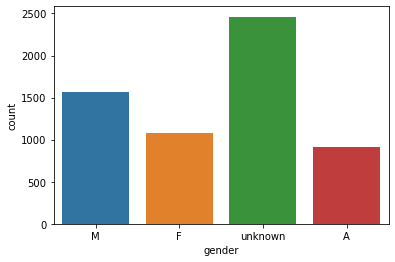

In [23]:
sns.countplot(x = "gender",
             data = characters_ng1_df)
plt.savefig('../data_visualization/gender_update2.png')
plt.show()
# still a lot of unknown genders, but more than half were resolved

## Another pass at gender markers: identifying first names

One of the last characters in the dataframe is "Stuart Smith" which made me think about split the `character_name` column to see if NLTK names would work on first names.

In [24]:
# df for characters without gender markers
characters_ng2_df = characters_ng1_df[characters_ng1_df.gender == 'unknown']

# df for characters with gender markers, these will get remerged later
characters_g2_df = characters_ng1_df[characters_ng1_df.gender != 'unknown']

In [25]:
characters_ng2_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
13,u13,AROJAZ,m1,1492: conquest of paradise,unknown,?
15,u15,BOBADILLA,m1,1492: conquest of paradise,unknown,?
20,u20,MENDEZ,m1,1492: conquest of paradise,unknown,?
21,u21,MOXICA,m1,1492: conquest of paradise,unknown,?
22,u22,PINZON,m1,1492: conquest of paradise,unknown,?


In [26]:
characters_g2_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
1,u1,BRUCE,m0,10 things i hate about you,M,?
3,u3,CHASTITY,m0,10 things i hate about you,F,?
8,u8,MISS PERKY,m0,10 things i hate about you,F,?
10,u10,SHARON,m0,10 things i hate about you,F,?
12,u12,ALONSO,m1,1492: conquest of paradise,M,?


In [27]:
# some characters are named like "Chuck/Captain" so I will also split by /
# some characters are named like "Helen's Voice" so I will split by '
characters_ng2_df['split_name'] = characters_ng2_df.character_name.map(lambda x: re.split("/| |'", x))

<ipython-input-27-1102011c8835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng2_df['split_name'] = characters_ng2_df.character_name.map(lambda x: re.split("/| |'", x))


In [28]:
# modifying the function above to look at just the first item in the list
def getGender2(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    name = name[0].upper()  # uppercase incoming name
    if name in nltkname_mf: return 'A'
    elif name in nltkname_f: return 'F'
    elif name in nltkname_m: return 'M'
    else:
        return 'unknown'

In [29]:
characters_ng2_df['gender'] = characters_ng2_df['split_name'].map(getGender2)

<ipython-input-29-d26d63e36a8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng2_df['gender'] = characters_ng2_df['split_name'].map(getGender2)


In [30]:
characters_ng2_df.tail()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
9030,u9030,DURNFORD,m616,zulu dawn,unknown,?,[DURNFORD]
9031,u9031,MELVILL,m616,zulu dawn,unknown,?,[MELVILL]
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,unknown,?,[NORRIS-NEWMAN]
9033,u9033,STUART SMITH,m616,zulu dawn,M,?,"[STUART, SMITH]"
9034,u9034,VEREKER,m616,zulu dawn,unknown,?,[VEREKER]


In [31]:
characters_ng2_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position,split_name
gender,,,,,,
A,48,48,48,48,48,48
F,44,44,44,44,44,44
M,108,108,108,108,108,108
unknown,2261,2261,2261,2261,2261,2261


Added another 200 gender markers.

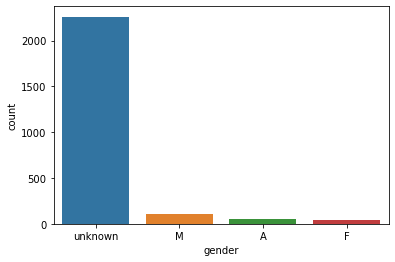

In [32]:
sns.countplot(x = "gender",
             data = characters_ng2_df)
plt.savefig('../data_visualization/gender_update3.png')
plt.show()
# still majority unknown, but a small bump for the other markers.

Some character's first names come second in the list of split names, like "Detective Neal"

In [33]:
# separate the dfs again

# df for characters without gender markers
characters_ng3_df = characters_ng2_df[characters_ng2_df.gender == 'unknown']

# df for characters with gender markers, these will get remerged later
characters_g3_df = characters_ng2_df[characters_ng2_df.gender != 'unknown']

In [34]:
characters_ng3_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
13,u13,AROJAZ,m1,1492: conquest of paradise,unknown,?,[AROJAZ]
15,u15,BOBADILLA,m1,1492: conquest of paradise,unknown,?,[BOBADILLA]
20,u20,MENDEZ,m1,1492: conquest of paradise,unknown,?,[MENDEZ]
21,u21,MOXICA,m1,1492: conquest of paradise,unknown,?,[MOXICA]
22,u22,PINZON,m1,1492: conquest of paradise,unknown,?,[PINZON]


In [35]:
characters_g3_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
43,u43,ROBERT HAWKINS,m2,15 minutes,M,?,"[ROBERT, HAWKINS]"
46,u46,STEPHEN GELLER,m2,15 minutes,M,?,"[STEPHEN, GELLER]"
148,u148,MEL GORDON,m10,affliction,A,?,"[MEL, GORDON]"
239,u239,VAN LEUWEN,m15,aliens,A,?,"[VAN, LEUWEN]"
267,u267,VON STRACK,m16,amadeus,M,?,"[VON, STRACK]"


In [36]:
def getGender3(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    if len(name) > 1:
        name = name[1].upper()  # uppercase incoming name
        if name in nltkname_mf: return 'A'
        elif name in nltkname_f: return 'F'
        elif name in nltkname_m: return 'M'
        else:
            return 'unknown'
    else:
        return 'unknown'

In [37]:
characters_ng3_df['gender'] = characters_ng3_df['split_name'].map(getGender3)

<ipython-input-37-fb80d17392ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng3_df['gender'] = characters_ng3_df['split_name'].map(getGender3)


In [38]:
characters_ng3_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position,split_name
gender,,,,,,
A,20,20,20,20,20,20
F,9,9,9,9,9,9
M,73,73,73,73,73,73
unknown,2159,2159,2159,2159,2159,2159


Added another 102 gender markers.

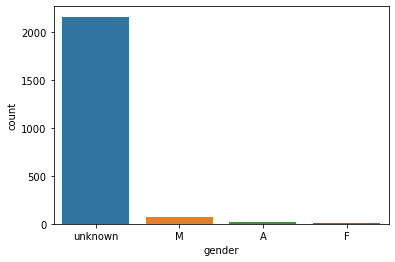

In [39]:
sns.countplot(x = "gender",
             data = characters_ng3_df)
plt.savefig('../data_visualization/gender_update4.png')
plt.show()
# smaller progress than the first pass, but still some progress

## Remerging the dataframes

In [40]:
# now that I have made progress on adding gender markers, I will add the dataframes back together
characters_update_df = pd.concat([characters_g1_df, characters_g2_df, characters_g3_df, characters_ng3_df])

In [41]:
# remove the "split name" and credit position columns
characters_update_df = characters_update_df[['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender']]

In [42]:
characters_update_df.head()

,character_ID,character_name,movie_ID,movie_title,gender
0,u0,BIANCA,m0,10 things i hate about you,F
2,u2,CAMERON,m0,10 things i hate about you,M
4,u4,JOEY,m0,10 things i hate about you,M
5,u5,KAT,m0,10 things i hate about you,F
6,u6,MANDELLA,m0,10 things i hate about you,F


In [43]:
characters_update_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title
gender,,,,
A,976,976,976,976
F,2099,2099,2099,2099
M,3799,3799,3799,3799
unknown,2159,2159,2159,2159


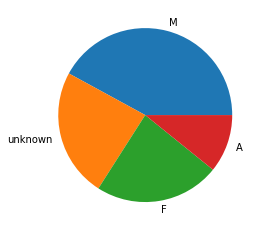

In [44]:
# another view of the gender split
plt.pie(characters_update_df.gender.value_counts(), labels=["M", "unknown", "F", "A"])
plt.savefig('../data_visualization/gender_pie_final.png')
plt.show()

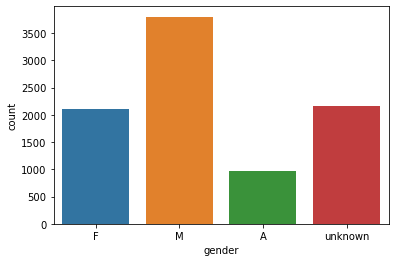

In [45]:
# updated dataframe gender breakdown
sns.countplot(x = "gender",
             data = characters_update_df)
plt.savefig('../data_visualization/gender_final.png')
plt.show()

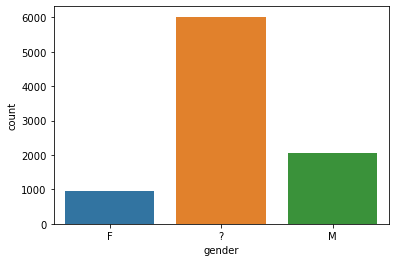

In [46]:
# compared to the original dataframe! huge improvement, I was able to cut the unknown gender markers down by half
sns.countplot(x = "gender",
             data = characters_df)
plt.show()
# this plot has already been saved above

## Pickling the data and creating a csv

In [47]:
import pickle

In [48]:
# pickle the data to use in other notebooks for further analysis
f = open('characters_update_df.pkl', 'wb')
pickle.dump(characters_update_df, f, -1)
f.close()

In [49]:
characters_update_df.to_csv('../new_data/characters_df.csv', header=True)

## Conclusion

Even though these data are pre-compiled, there was still some tidying and improvement I was able to do. Because my analysis focuses on gender representation in movies, getting more markers was integral to make the rest of my data and analysis as coherent as possible. I was able to fill in 3859 markers out of the original 6018 missing markers. This accounted for around 64% of the missing markers.

Some of the character names are in other languages, so if there was an NLTK names list equivalent in non-English languages, I would have been able to fill in more just from looking at names.